<a href="https://colab.research.google.com/github/TruongDuyLongPTIT/Hands-on-Machine-Learning/blob/main/House_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Đây là project: House_price_predict. Mình làm project này dựa trên sự hướng dẫn của cuốn sách Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. Đa phần code, các định nghĩa, các phương pháp đều được lấy từ trong cuốn sách. Ngoài ra, có 1 số kiến giải của riêng mình. Mục tiêu khi học chương này là để tìm hiểu 1 dự án Học máy được tổ chức như thế nào trong thực tế. Bên cạnh đó, cũng là để xem xét các lý thuyết đã học ở chương 1 được áp dụng vào thực tế như thế nào.

Mục đích: Sử dụng tập dữ liệu điều tra dân số của bang California để xây dựng mô hình dự đoán giá nhà tại bang. 
Lưu ý: Đơn vị địa lý nhỏ nhất mà cục điều tra dân số Hoa Kỳ sử dụng là block. Một block có khoảng từ 600 đến 3000 người. Để thuận tiện, mình gọi các block là các "quận".

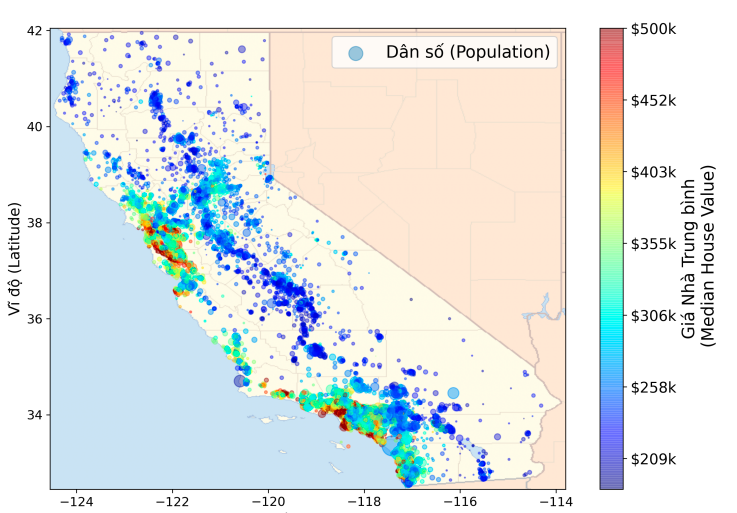

# Thu thập dữ liệu

In [69]:
# 1 số thư viện cần thiết
import tarfile
import urllib
import pandas as pd
import numpy as np

In [70]:
# Hàm này trả về 1 đối tượng DataFrames của pandas chứa toàn bộ dữ liệu
def load_housing_data():
  return pd.read_csv("/content/drive/MyDrive/datasets/housing/housing.csv")

## Xem nhanh qua Cấu trúc tập dữ liệu

In [71]:
# Tai du lieu
# Dung method head() của DataFrames de xem du lieu
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [72]:
# Method info() rất hữu dụng khi ta muốn xem các thông tin cơ bản của tập dữ liệu: Tổng số hàng, kiểu dữ liệu, số lương giá trị khác rỗng.
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [73]:
# Method value_counts() dùng để đếm tần số của các hạng mục.
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [74]:
# Method describe() mô tả tổng quan về dữ liệu.
# Ý nghĩa của count, min, max khá rõ ràng. Lưu ý: các giá trị rỗng được bỏ qua.
# std: cho biết độ lệch chuẩn, một phép đo độ phân tán của giá trị.
# 25%: nghĩa là có 25% mẫu giữ liệu nhỏ hơn 1 giá trị xác định. Ví dụ: Như bảng dưới thì có 25% quận có số lượng dân cư <= 787 người.
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [75]:
import matplotlib.pyplot as plt

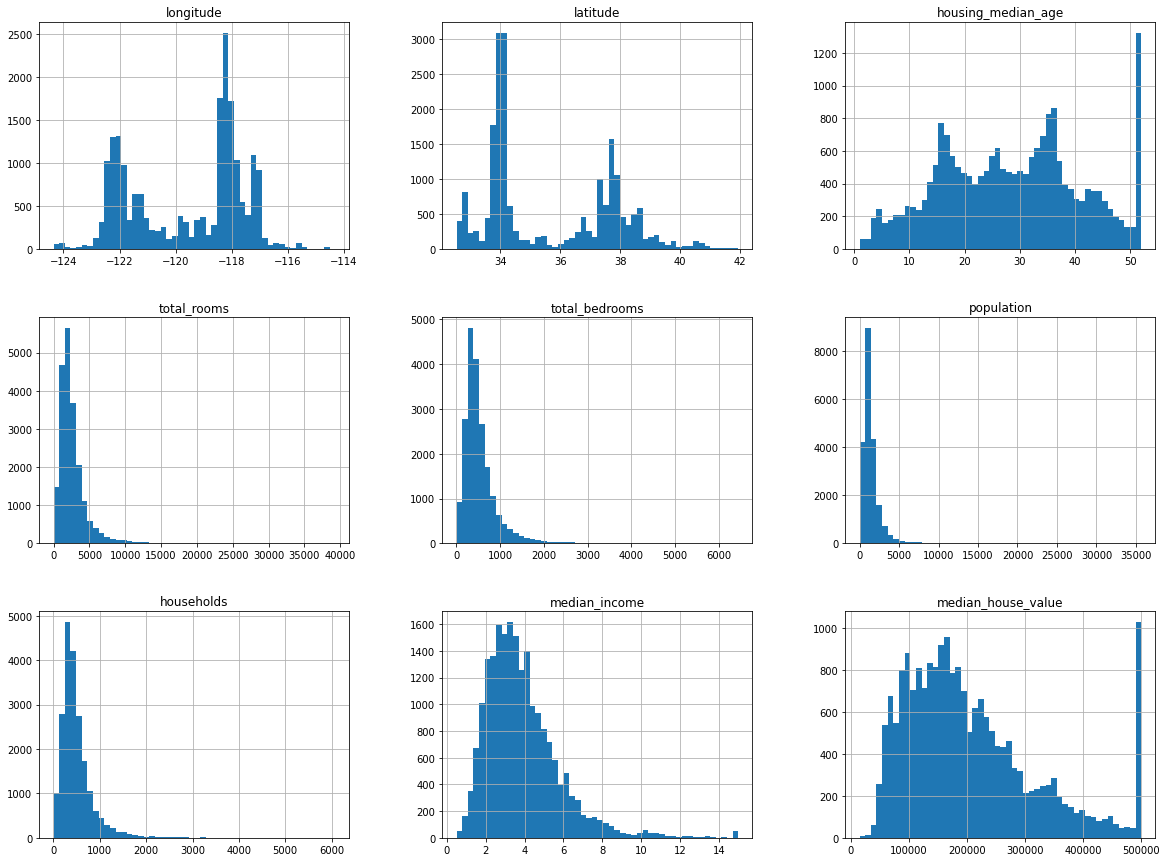

In [76]:
# Để vẽ biểu đồ tần suất cho từng thuộc tính ta dùng method hist()
housing.hist(bins=50, figsize=(20,15))
plt.show()

Nhìn vào các biểu đồ này thì ta thấy 1 số điểm cần lưu ý trong dữ liệu:
1. Biểu đồ median_income (thu nhập trung bình): dường như không được tính theo đơn vị đô-la Mỹ (hay 1 đơn vị tiền tệ nào khác). Khi gặp trường hợp này, thì phải hỏi rõ lại người làm công việc tiền xử lý dữ liệu. Sau khi hỏi, họ thông báo rằng: đang dùng đơn vị 10000\$ (tức là 1 ~ 10000\$, 2 ~ 20000\$, 0,5 ~ 5000\$).

2. Điều thứ 2 những người tiền xử lý giữ liệu cho chúng ta biết: họ đã định mức giá trần là 15000\$ và mức giá sàn là 5000\$. Tức là, nếu thu nhập trung bình của 1 quận nào đó mà dưới mức sàn (5000\$) thì họ sẽ gán thu nhập của quận đó bằng mức sàn. Ví dụ: Quận_A.median_income = 4500$ thì họ sẽ gán cho Quận_A.median_income = 5000\$. Tương tự, nếu median_income của 1 quận nào đó mà > 150000\$ thì gán nó bằng 150000\$. (Còn lý do tại sao họ giới hạn mức sàn và mức trần thì mình cũng chưa biết).

3. **Quan trọng**: Dữ liệu median_house_value (giá nhà trung bình) cũng bị giới hạn mức sàn và mức trần. Việc giới hạn mức trần và mức sàn cho thuộc tính median_house_value khá nguy hiểm vì đây là thuộc tính quan trọng nhất để chúng ta đưa ra dự đoán chính xác. Ví dụ: Quận B ở gần biển nên giá của nó rất cao, Quận_B.median_house_value = 750000$ nhưng giá trần của median_house_value = 500000\$ nên Quận_B.median_house_value phải bằng 500000\$. Điều này dẫn đến hậu quả là: khi ta dự đoán giá 1 ngôi nhà trong quận B sẽ bị chênh lệch so với thực tế rất nhiều. Chúng ta cần phải cảnh báo với khách hàng (những người dùng hệ thống để dự đoán) là: Nếu bạn nhận được dự đoán ngôi nhà bạn mua có giá ~ 500000\$ thì **có thể** thực tế nó còn cao hơn thế.
  *   Nếu khách hàng chấp nhận được điều này thì ta train model bình thường với tập dữ liệu đã có.
  *   Nếu khách hàng yêu cầu hệ thống phải dự đoán tốt kể cả với những ngôi nhà có giá vượt ngưỡng trần thì ta có thể dùng 2 cách sau:

    1.   Thu thập nhãn thích hợp cho những quận nhà có nhãn bị giới hạn.
    2.   Loại bỏ những tập đó ra khỏi tập huấn luyện (cũng như tập kiểm tra vì hệ thống không nên bị đánh giá tệ mỗi khi dự đoán giá trị trên ngưỡng 500000\$). <?1>

4. Các khoảng thuộc tính này có khoảng giá trị rất khác nhau. (Sẽ tìm hiểu điều này ở phần co dãn đặc trưng).

5. Nhiều biểu đồ có xu hướng nặng đuôi (tail-heavy): biểu đồ trải dài về bên phải trung vị hơn bên trái. Điều này sẽ khiến việc nhận dạng các khuôn mẫu trong 1 số thuật toán Học máy khó khăn <?2>. Về sau thì ta sẽ cố gắng chuyển các biểu đồ này về dạng hình chuông <?3>.









**<?> Câu hỏi:**
1. Nếu làm như vậy thì hệ thống có thể dự đoán khá chính xác đối với những ngôi nhà có giá trị <= 500000\$ nhưng làm thế nào để dự đoán tốt khi giá trị nhà vượt quá ngưỡng 500000\$ nhỉ?
2. Tại sao tail-heavy lại khiến mô hình khó khăn trong việc phát hiện khuôn mẫu?
3. Tại sao chuyển về dạng hình vuông lại dễ xác định khuôn mẫu hơn?

**<*> Trả lời:**
1. Chưa có câu trả lời thuyết phục.
2. Chưa có câu trả lời thuyết phục.
3. Chưa có câu trả lời thuyết phục.

## Tạo tập kiểm tra.

Bây giờ chúng ta đã xem qua một số đặc điểm của dữ liệu. Trước khi đi vào xem xét kỹ dữ liệu để lựa chọn mô hình phù hợp, ta cần làm 1 việc hết sức quan trọng. Đó là trích 1 phần của data_set (thông thường khoảng 20%) để làm test_set. **Sau khi có test_set hãy để chúng sang 1 bên và tuyệt đối không "xem lén" chúng**. Nếu không, bạn sẽ rất dễ dính bẫy *thiên kiến dòm ngó (data-snooping)*.

Nguyên nhân xảy ra *thiên kiến dòm ngó* có thể coi là do khả năng phát hiện khuôn mẫu tuyệt vời của bộ não con người. Khi nhìn vào 1 tập dữ liệu, thì não bộ con người có thể phát hiện ra những khuôn mẫu thú vị trong đó. Vì thế, nếu chúng ta nhìn vào test_set thì sẽ nhiều khả năng sẽ phát hiện ra những khuôn mẫu tồn tại trong chúng. Và khi đó, chúng ta rất có khả năng thiết kế ra một mô hình dựa trên những khuôn mẫu tìm được trong test_set. Do đó, mô hình bị quá khớp trên test_set sẽ là điều đương nhiên.

**<?> Câu hỏi:**
1. Tại sao cần trích xuất ra test_set từ trước khi chọn mô hình? Nếu trích test_set sau khi chọn mô hình thì sao?

**<*> Trả lời:** 
1. Chưa có câu trả lời thuyết phục

~ Một số cách code để tạo tập kiểm tra:




In [77]:
#Cách tạo test_set đơn giản nhất nhưng không hoàn hảo.
import numpy as np

def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int (len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]



In [78]:
train_set, test_set = split_train_test(housing, 0.2)

In [79]:
len(train_set)

16512

In [80]:
len(test_set)

4128

Cách này ổn, nhưng không hoàn hảo! Vì mỗi khi ta chạy lại chương trình nó lại tạo ra 1 tập kiểm tra khác. Dần dần, bạn (hoặc thuật toán Học máy) sẽ nhìn thấy toàn bộ tập dữ liệu. Như vậy ta lại vô tình mắc phải bẫy *thiên kiến dòm ngó*.

Có 2 cách hữu ích để giải quyết vấn đề này:

Cách 1: Chỉ chạy hàm split_train_test() 1 lần duy nhất. Kết quả của nó là train_set và test_set sẽ được lưu lại và sử dụng cho những lần sau.

Cách 2: Cài đặt seed cho bộ sinh số ngẫu nhiên (ví dụ: np.random.seed(42)) trước khi gọi hàm np.random.permutation() để nó luôn hoán vị tập dữ liệu theo đúng 1 cách duy nhất. Nhờ vậy mà train_set và test_set vẫn sẽ không thay đổi dù thuật toán Học máy có được chạy lại.

Tuy nhiên cả 2 cách trên cũng không hoạt động trong trường hợp tập dữ liệu được cập nhật. Để có một cách chia ổn định ngay cả trong trường hợp này, một giải pháp thông dụng là sử dụng ID của của mỗi mẫu để quyết định xem liệu nó có thuộc test_set hay không (giả sử mỗi mẫu có 1 ID duy nhất và bất biến). Ví dụ, bạn có thể tính toán hash của ID mỗi mẫu và đưa mẫu đó vào test_set nếu hash thấp hơn hoặc bằng 20% giá trị hash lớn nhất. Việc này đảm bảo rằng tập kiểm tra trong các lần chạy luôn luôn đồng nhất, kể cả khi bạn cập nhật dữ liệu. Tập kiểm tra sẽ chứa 20% mẫu mới, nhưng nó sẽ không chứa bất kỳ mẫu nào trước đó thuộc về tập huấn luyện (**Đoạn này chưa hiểu lắm!!**).

In [81]:
# Code mô phỏng ý tưởng trên:
from zlib import crc32

def test_set_check(indentifier, test_ratio):
  return crc32(np.int64(indentifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

# Tuy nhiên, tập dữ liệu nhà ở không có cột ID. Cách đơn giản nhất là sử dụng luôn chỉ số hàng làm ID.
housing_with_id = housing.reset_index() # thêm cột 'index'
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

# Nếu sử dụng chỉ số hàng làm ID duy nhất, ta cần đảm bảo rằng dữ liệu mới được nối vào cuối tập dữ liệu và không hàng nào bị xóa sau này. 
# Nếu cách này không khả thi, ta có thể sử dụng đặc trưng ỔN ĐỊNH NHẤT để tạo ID độc nhất. Ví dụ: kinh độ, vĩ độ của một quận được đảm bảo 
# ổn định tới vài triệu năm, nên ta có thể kết hợp chúng thành một ID (Tuy nhiên, trong thực tế dữ liệu về kinh độ, vĩ độ khá thô. 
# Nên 1 số quận gần nhau sẽ có thể có cùng kinh độ, vĩ độ. Dẫn đến hậu quả là ID của các quận này sẽ bằng nhau. Và do ID bằng nhau nên 
# chúng sẽ luôn nằm cùng 1 tập dữ liệu (train_set hoặc test_set). Điều này có thể dẫn đến một số thiên kiến không mong muốn khi lấy mẫu.):

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id" )

In [82]:
# Thư viện Scikit-Learn cung cấp 1 vài hàm để chia 1 tập dữ liệu ra thành các tập dữ liệu con theo nhiều cách. 
# Hàm đơn giản nhất là train_test_split(), hoạt động gần giống với hàm split_train_test(), với 1 vài chức năng bổ sung. 
# Đầu tiên là tham số random_state cho phép ta đặt seed cho bộ sinh số ngẫu nhiên. 
# Thứ hai, ta có thể truyền vào nhiều tập dữ liệu có cùng số hàng, và hàm này sẽ chia các tập dữ liệu theo cùng 1 cách
# (điều này rất hữu ích, ví dụ khi bạn có 1 DataFrame riêng cho nhãn):

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [83]:
len(train_set)

16512

In [84]:
len(test_set)

4128

**Lưu ý:** 

Các phương pháp lấy mẫu ngẫu nhiên như đã đề cập ở trên thường sẽ hoạt động tốt khi tập dữ liệu của bạn đủ lớn. Nhưng trong trường hợp dữ liệu của bạn không đủ lớn thì việc lẫy mẫu ngẫu nhiên rất dễ dính bẫy *thiên kiến lấy mẫu*.

Dữ liệu thì không phải lúc nào muốn thu thập thêm là được nên ta phải tìm ra 1 cách để tránh được *thiên kiến lấy mẫu* khi mô hình hoạt động dựa trên các tập dữ liệu nhỏ. *Lấy mẫu Stratified (Stratified Sampling)* là một phương pháp lấy mẫu hữu dụng trong trường hợp này. 

Trong phương pháp *Lấy mẫu Stratified*: Tổng thể dữ liệu (population) sẽ được chia ra thành các nhóm con đồng nhất. Mỗi nhóm con này được gọi là 1 *stratum*, tập hợp các *stratum* người ta gọi là *strata*.

Để cho dễ hình dung, tôi có 1 hình ảnh mô tả rõ ràng phương pháp lấy mẫu này:
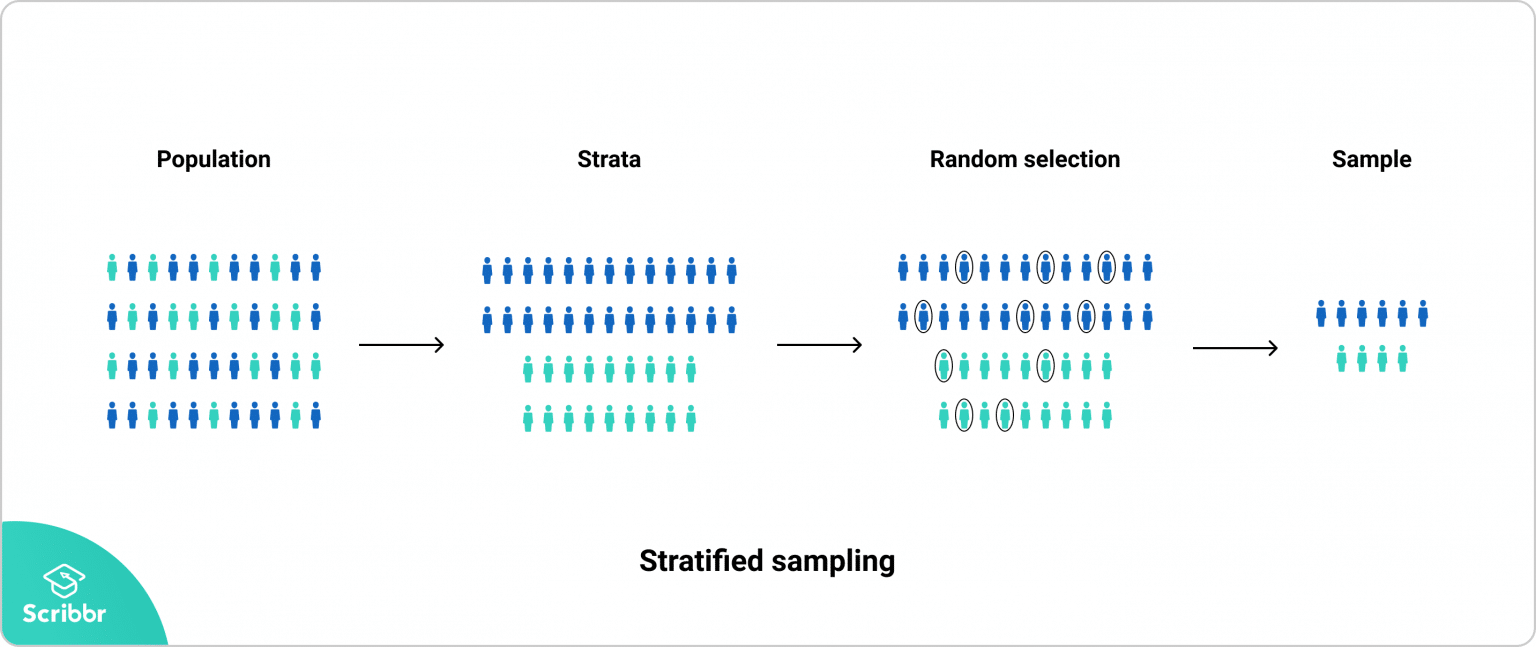


*Mục đích của phương pháp này là để có thể lấy được 1 tập dữ liệu có tính đại diện cho 1 tổng thế nào đó.*

Ví dụ: Có 1 công ty Mỹ, muốn làm khảo sát đối với 1000 người. Họ muốn chọn làm sao để 1000 người này có thể đại diện cho toàn bộ dân số nước Mỹ. Dân số Mỹ thì có 51.3% nữ và 48.7% nam, nên một cuộc khảo sát tốt sẽ cố gắng duy trì tỉ lệ này, cụ thể là họ sẽ khảo sát: 513 nữ vào 487 nam. 

*Lưu ý:*

Khi áp dụng phương pháp *Stratified sampling* thì không nên chia *population (data_set)* ra thành quá nhiều *stratum*. Chỉ cần 1 số lượng vừa đủ *stratum* và những stratum đó nên đủ lớn.

Lý do cho việc này là, nếu chia thành nhiều *stratum* đồng nghĩa kích cỡ của mỗi *stratum* sẽ tương đối nhỏ. Việc này có thể sẽ khiến cho chúng ta đánh giá sai lệch tầm quan trọng của các *stratum*. 

Ví dụ: Khảo sát độ tuổi của người dân tại Mỹ để vẽ tháp dân số. Sau đó, người ta sẽ dựa vào khảo sát này để đưa ra nhận định dân số nước Mỹ đang có xu hướng già hóa/ trẻ hóa hay đang ở mức cân bằng. 

- Giả sử, sau khi khảo sát, nhóm khảo sát có 10.000 mẫu dữ liệu (đây chính là *population hay data_set*).

- Họ chia toàn bộ *population* ra thành 4 *stratum*: Thiếu niên(<=19 tuổi) chiếm 20%, Thanh niên (20-35 tuổi) chiếm 15%, Trung niên (35-55 tuổi) chiếm 40%, Lão niên (55-85 tuổi) chiếm 25%.

- Với cách chia như vậy số lượng mẫu ở trong mỗi *stratum* này sẽ đủ lớn để có thể phản ánh tương đối chính xác tỷ lệ giữa các độ tuổi trong thực tế. Thật vậy, trong thực tế trên 50.000.000 triệu dân Mỹ, thì tỷ lệ độ tuổi Thiếu niên:Thanh niên:Trung niên:Lão niên = 20.5%14.6%:40,1%:24.8% gần giống với tỷ lệ trong tập 10.000 mẫu dữ liệu mà chúng ta có. Đó là lý do tôi nói rằng khi *stratum* đủ lớn thì nó mới có thể có tính đại diện cho toàn bộ dân số nước Mỹ trong thực tế.

- Ngược lại, nếu ta chia *population (hay data_set mà chúng ta có)* ra thành rất nhiều *statum*: 2tuổi, 3 tuổi, ...,20 tuổi, 21 tuổi, ..., 50 tuổi, 51 tuổi, ..., 85 tuổi. Như vậy, số lượng mẫu trong mỗi *stratum* này là rất nhỏ, không đủ để đại diện cho số lượng người thuộc từng độ tuổi trong thực tế. Ví dụ: Trong thực tế có: (9.000 người 84 tuổi) và (6000 người 85 tuổi) (tỷ lệ 84 tuổi:85 tuổi = 3/2) nhưng trong tập dữ liệu thì chỉ có (90 người - 84 tuổi) và (45 người - 85 tuổi) như vậy (tỷ lệ 84 tuổi:85 tuổi = 2). Như vậy, khi ta chia ra quá nhiều *stratum* và mỗi *stratum* không đủ lớn thì sẽ có xác xuất rất cao ta sẽ đánh giá sai tỷ lệ giữa các độ tuổi. 


Và đương nhiên, khi tỷ lệ giữa các *stratum* sai lệch nhiều so với thực tế thì tỷ lệ các *mini_stratum* trong test_set cũng sẽ bị sai lệch theo. (Vì tỷ lệ giữa các *mini_stratum* trong test_set luôn ~/= (xấp xỉ hoặc bằng) tỷ lệ giữa các *stratum*.

**Như vậy, việc có đủ lượng mẫu trong mỗi *stratum* là rất quan trọng. Nếu không việc ước lượng độ quan trọng của mỗi *stratum* sẽ bị thiên kiến.**

**Tóm lại: Không nên có quá nhiều *stratum* và mỗi *stratum* nên đủ lớn.**

`Phỏng đoán cá nhân`

---


Thêm 1 chút hiểu về *thiên kiến lấy mẫu*:

- *Thiên kiến lấy mẫu* là: vì một lý do nào đó mà tập mẫu (hay tập dữ liệu) của chúng ta không phản ánh đúng thực tế, không có tính đại diện cho lượng lớn dữ liệu trong thực tế (Nguyên nhân xảy ra hiện tượng này có thể do khách quan (do rủi ro khi thu thập dữ liệu) hoặc chủ quan (pp lấy mẫu sai, pp chia *stratum* sai, ...)).
- Tìm cách chống lại *thiên kiến lấy mẫu* chính là tìm cách để sao cho dữ liệu phản ảnh thực tế tốt nhất, có tính đại diện cao.
- 1 số phương pháp cụ thể chống lại *thiên kiến lấy mẫu*:
  
  - Khi mục đích là thu thập 1 tập dữ liệu lớn thì:
    + Chỉ cần cố gắng đảm bảm *tính ngẫu nhiên* khi thu thập dữ liệu. Và khi đó *luật số lớn* trong xác suất thống kê sẽ giúp chúng ta chống *thiên kiến lấy mẫu*. 
    + Khi ta tung 1 đồng xu đồng chất, nếu chỉ tung 1 vài lần thì tỷ lệ giữa mặt xấp và mặt ngửa sẽ chênh lệch rất lớn khoảng 1/3, 1/4, hoặc hơn..., nhưng khi ta tung đồng xu đó N lần (với N đủ lớn) thì tỷ lệ xấp/ngửa sẽ tiến đến 1/2 tức là xác xuất mỗi mặt ~ 50% (đạt được sự ngẫu nhiên). Đây chính là *luật số lớn*.
    + Tương tự vậy, nếu ta chỉ lấy ngẫu nhiên 1 ít dữ liệu, thì tỷ lệ giữa các *stratum* của nó sẽ chênh lệch rất lớn. Nhưng khi lấy được càng nhiều dữ liệu thì tỷ lệ giữa các *stratum* sẽ ngày càng tự nhiên hơn (sát với thực tế hơn). Ví dụ: Ở Việt Nam, Tỉ lệ Nam:Nữ = 45:55. Khi ta thu thập được 100 mẫu dữ liệu thì người ta thấy trong đó có 60 nữ, 40 nam (tỷ lệ Nam:Nữ = 40/60). Khi ta thu thập được 1000 mẫu dữ liệu thì tỷ lệ Nam:Nữ = 44:56. Khi ta thu thập được 10.000 mẫu dữ liệu thỉ tỷ lệ Nam:Nữ = 45,5:54.5. Khi ta thu thập được 100.000 mẫu dữ liệu thì tỷ lệ Nam:Nữ ~ 45:55 (hiện tượng này được giải thích bằng *luật số lớn* được đề cập ở trên). 
    + Tóm lại:
      - Khi thu thập dữ liệu cần đảm bảo tính *ngẫu nhiên*.
      - Thu thập càng nhiều dữ liệu thì tỷ lệ giữa các *stratum* càng sát với thực tế. Như vậy, tập dữ liệu có tính khái quát (đại diện) cao hơn (đồng nghĩa với ta đã chống lại được *thiên kiến lấy mẫu*).

  - Nếu mục đích là thu thập 1 tập dữ liệu nhỏ thì:
    + Khi mà tập dữ liệu nhỏ thì *luật số lớn* sẽ không hoạt động. Do đó ta phải áp dụng *Stratified Sampling* để đảm bảo tập dữ liệu có tính đại diện cao.
    + Cốt lõi của phương pháp *Stratified Sampling* là: cần cố gắng thu thập dữ liệu sao cho tỷ lệ các *stratum* trong data_set tương tự tỷ lệ *stratum* trong thực tế. VD: Tại Mỹ, tỷ lệ Nam:Nữ = 54:46 thì khi lấy 1000 mẫu dữ liệu thì nên lấy 540 Nam và 460 Nữ. 

Quay lại bài toán mà chúng ta đang giải quyết: House_price_predict. 

Tập dữ liệu mà chúng ta có gồm 20640 mẫu. Đây là một tập dữ liệu tương đối nhỏ. Vì vậy, để đảm bảo *test_set* có tính khái quát tốt, ta nên dùng phương pháp *Stratified Sampling*. 

Có 2 câu hỏi quan trọng cần đặt ra sau khi quyết định chọn phương pháp *Stratified Sampling*, đó là: 
  + Nên chọn thuộc tính nào? 
  + Dựa trên thuộc tính đó thì nên chia tập dữ liệu thành những *stratum* nào?

Nhìn lại ví dụ khảo sát dân số ở trên. Thì ta đã chọn thuộc tính: *giới tính* và dựa trên thuộc tính này để chia tập dữ liệu thành 2 *stratum: Nam và Nữ*.

Trong bài toán của chúng ta thì thuộc tính: *thu nhập trung vị* đóng vai trò rất quan trọng trong việc dự đoán *giá nhà trung vị*. Vậy nên, chúng ta lựa chọn thuộc tính này để chia tập dữ liệu ra thành các *stratum*.

Vì *thu nhập trung vị* là một thuộc tính có tính liên tục, nên ta phải tạo thuộc tính có tính hạng mục để biểu diễn các mức thu nhập khác nhau.
Thuộc tính hạng mục chúng ta tạo có tên: income_cat (mức thu nhập).


In [85]:
# Đoạn mã dưới đây sử dụng hàm pd.cut() để tạo thuộc tính mức thu nhập (income_cat). 
# Thuộc tính này gồm 5 mức (gán nhãn từ 1 đến 5): Mức 1: từ 0 -> 1.5 (tức dưới 15.000$); Mức 2: từ 1.5 -> 3, ....

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1,2,3,4,5])

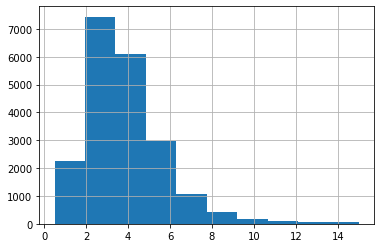

In [86]:
housing["median_income"].hist()


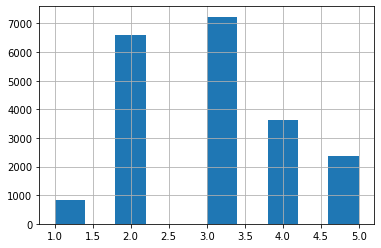

In [87]:
# Biểu đồ biểu diễn tần số các Mức thu nhập
housing["income_cat"].hist()

Như vậy, bạn có thể nhận ra, tập dữ liệu của chúng ta đã được phân thành 5 *stratum* tương ứng với 5 mức thu nhập. Tập các mẫu dữ liệu thuộc mức 1 chính là *stratum_1*, tập các mẫu dữ liệu thuộc mức 2 chính là *stratum_2*, ....

In [88]:
# Bây giờ, ta đã sẵn sàng lấy mẫu theo phương pháp Stratified Sampling dựa trên các mức thu nhập.
# Để thực hiện việc này, ta có thể sử dụng lớp StratifiedShuffleSplit.

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [89]:
# Ta quan sát tỷ lệ xem đoạn mã trên có hoạt động đúng như ta mong muốn không.
# Xem tỷ lệ phần trăm của các mức thu nhập trên test_set.
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [90]:
# Xem tỷ lệ phần trăm các mức thu nhập trên data_set.
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Ta thấy tỷ lệ phần trăm các mức thu nhập ở trong test_set và data_set là gần như nhau. Như vậy, ta đã thực hiện thành công Stratified Sampling.

Bảng dưới đây so sánh tỷ lệ phần trăm của các mức thu nhập trong toàn bộ dữ liệu và trong tập dữ liệu kiểm tra được tạo ra bởi Stratified Sampling và lấy mẫu ngẫu nhiên. Có thể thấy, Stratified Sampling tạo ra tập dữ liệu kiểm tra có tỷ lệ các mức thu nhập khá giống với tỷ lệ trong tập dữ liệu gốc, trong khi phân phối của tập dữ liệu kiểm tra sử dụng phương pháp lấy ngẫu nhiên lại bị lệch.

In [91]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [92]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


Giờ ta có thể loại bỏ thuộc tính: income_cat để tập dữ liệu trở về trạng thái ban đầu.

In [93]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

**Note:** 

  + Giai đoạn: sinh tập kiểm tra (test_set) là cực kỳ quan trọng trong những dự án Học máy nhưng lại thường không được coi trọng.

**Tóm tắt:**

Một vài cách tạo tập kiểm tra thông dụng:

~ Tạo tập kiểm tra dựa trên phương pháp lấy mẫu ngẫu nhiên - tức nhặt random dữ liệu trong data_set để cho vào test_set (áp dụng được cho tập dữ liệu lớn):
1. Chọn random khoảng 20% trong data_set.
  + Ưu điểm: Ý tưởng và code đơn giản.
  + Nhược điểm: 
    + Khi chạy lại chương trình thì nó sẽ sinh ra 1 tập kiểm tra khác. Như vậy, mô hình (và bạn) dần dần sẽ nhìn thấy toàn bộ test_set (thiên kiến dòm ngó). 
    + Không hoạt động tốt đối với tập dữ liệu nhỏ. Vì dữ liệu trong test_set quá ít không có tính đại diện.
2. Chạy hàm sinh tập dữ liệu một lần duy nhất. Các lần sau sử dụng train_set và test_set được tạo từ lần đầu.
  + Ưu điểm: Tránh được thiên kiến nhòm ngó.
  + Nhược điểm: 
    + Không hoạt động tốt đối với tập dữ liệu nhỏ. Vì dữ liệu trong test_set quá ít không có tính đại diện.
    + Không thích nghi được với dữ liệu mới khi tập dữ liệu được cập nhật.
3. Cài đặt seed cho bộ sinh số ngẫu nhiên (ví dụ: np.random.seed(42)) trước khi gọi hàm np.random.permutation() để nó luôn hoán vị tập dữ liệu theo đúng 1 cách duy nhất. Nhờ vậy mà train_set và test_set vẫn sẽ không thay đổi dù thuật toán Học máy có được chạy lại.
  + Ưu điểm: Tránh được thiên kiến dòm ngó.
  + Nhược điểm: 
    + Không hoạt động tốt đối với tập dữ liệu nhỏ. Vì dữ liệu trong test_set quá ít không có tính đại diện.
    + Không thích nghi được với dữ liệu mới khi tập dữ liệu được cập nhật. (Chưa hiểu tại sao lại không thích nghi được, rõ ràng là nếu cập nhật dữ liệu thì hàm sinh test_set nó sẽ lấy input là tập dữ liệu mới và từ đó sinh ra train_set và test_set mới mà???).
4. Quyết định mẫu nào thuộc train_set, mẫu nào thuộc test_set dựa trên tính toán giá trị băm của ID các mẫu. Nếu mẫu có hash(ID) <= 20% giá trị hash_max thì nó thuộc tập kiểm tra. 
  + Ưu điểm: Chống lại được thiên kiến dòm ngó, hoạt động tốt ngay cả khi dữ liệu được cập nhật.
  + Nhược điểm: 
    + Không hoạt động tốt khi tập dữ liệu nhỏ. Vì dữ liệu trong test_set quá ít không có tính đại diện.
    + Nếu trường hợp tập dữ liệu không có ID, thì phải tạo ID cho nó. Thường dùng các đặc trưng có tính bất biến để tạo ID. Tuy nhiên, nhiều khi ID của 1 số mẫu có thể bị trùng nhau (như trường hợp trong bài này). Điều đó khiến các mẫu bị trùng ID chắc chắn cùng thuộc về 1 tập (hoặc train_set hoặc test_set). Như thế sẽ gây ra thiên kiến lấy mẫu.

~ Tạo tập kiểm tra dựa trên phương pháp lấy mẫu không hoàn toàn ngẫu nhiên - tức đưa ra 1 số giới hạn hay ràng buộc nào đó, rồi cho lấy ngẫu nhiên sao cho vẫn thỏa mãn các giới hạn/ ràng buộc đó. 
5. Tất cả các cách trên đều không hoạt động tốt với tập dữ liệu nhỏ. Điều này dễ hiểu vì không đủ dữ liệu luôn luôn là 1 thách thức lớn đối với Học máy. Tuy nhiên, phương pháp Stratified Sampling xuất hiện như một vị cứu tinh trong trường hợp này. 
  + Ưu điểm: Hoạt động được trong trường hợp tập dữ liệu "khiêm tốn".
  + Nhược điểm: Có 1 số nhược điểm nhưng ít gặp trong thực tế.

# Khám phá và trực quan hóa để hiểu Dữ liệu


Câu hỏi đầu section:
1. Chúng ta cần tìm hiểu điều gì từ dữ liệu?

Chúng ta thực hiện trực quan hóa tập huấn luyện. Nếu tập huấn luận quá lớn, chúng ta chỉ cần lấy 1 phần để thao tác. Trong tường hợp này, tập huấn luyện khá nhỏ nên ta thao tác trên toàn bộ tập. Ta tạo 1 bản copy của tập huấn luyện để tránh thay ảnh hưởng tới tập huấn luyện gốc.

In [94]:
housing = strat_train_set.copy()

## Trực quan hóa dữ liệu Địa lý

Vì dữ liệu có thông tin về địa lý: Kinh độ, vĩ độ. Nên ta tạo 1 biểu đồ phân tán (scatterplot) của tất cả các quận để trực quan hóa chúng.

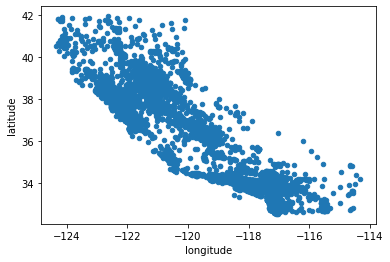

In [95]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Đương nhiên, biểu đồ này có hình dáng tương đối giống bang California. Tuy nhiên, để có thể tìm khuôn mẫu dễ dàng hơn, ta cần đặt tham số alpha = 0.1 để minh họa tốt hơn mật độ dân cư ở các vùng.


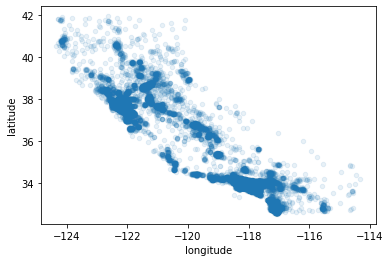

In [96]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Biểu đồ trên vẫn chưa nói được nhiều điều. Ta cần thêm:
  + Mật độ dân số: Nếu quận càng đông thì vòng tròn càng lớn.
  + Giá nhà: Nếu giá nhà càng đắt thì màu càng chói.

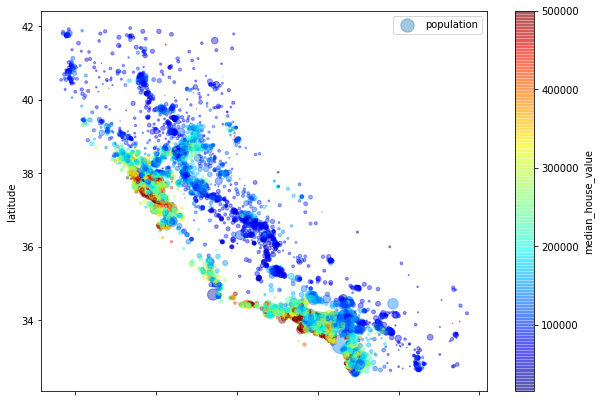

In [97]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7), 
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,             
)
plt.legend()

Như ta thấy, giá nhà liên quan mật thiết với mật độ dân số và vị trí. Ví dụ: khu vực đông dân thì giá nhà THƯỜNG sẽ cao hơn, khu vực gần biển thì giá nhà THƯỜNG sẽ cao hơn.

Một thuận toán phân cụm sẽ hữu ích để phát hiện các cụm chính. Từ đó, có thể bổ sung đặc trưng mới là khoảng cách từ mẫu đến tâm cụm. Khoảng cách đến biển cũng rất hữu ích, tuy vậy ở phía Tây Bắc California, các quận vùng vịnh giá nhà lại không quá cao, do vậy đây không phải là 1 quy luật đơn giản.

## Tìm sự Tương quan

Vì tập dữ liệu không quá lớn. Nên ta có thể dễ dàng tính được hệ số *tương quan chuẩn (standard correlation coefficient) hay còn gọi là Hệ số tương quan Pearson r* của các cặp thuộc tính bằng phương thức corr().

In [98]:
corr_matrix = housing.corr()

Quan sát sự tương quan của giá nhà trung vị với các thuộc tính khác.

In [99]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Hệ số tương quan nằm trong khoảng -1 đến 1. Càng gần 1, mức tương quan càng dương; ví dụ, giá nhà trung vị có xu hướng tăng khi thu nhập trung vị tăng. Ngược lại, càng gần -1, mức tương quan càng âm; ví dụ: giá nhà hơi có xu hướng giảm đi khi đi lên phía Bắc).

Lưu ý: Hệ số tương quan chỉ đo lường sự tương quan tuyến tính. Còn sự tương quan phi tuyến thì hệ số tương quan không thể hiện được.

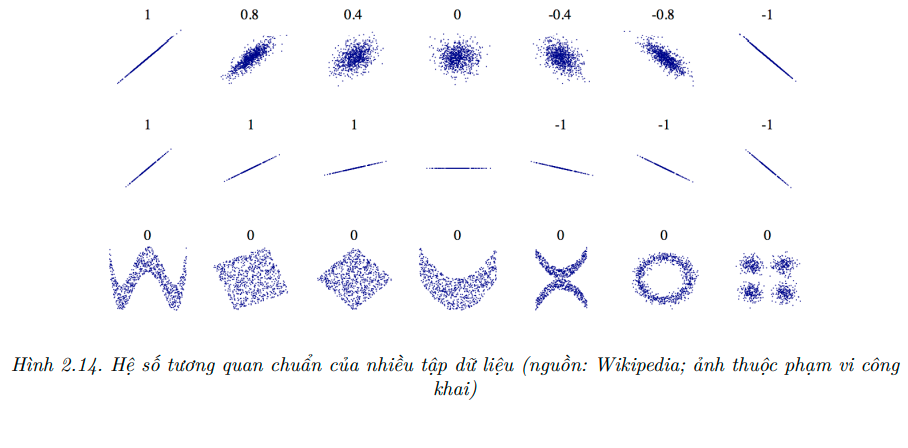

Một cách khác trực quan hơn là vẽ scatterplot để biểu diễn mối quan hệ giữa các thuộc tính với nhau. Ta có thể dùng hàm scatter_matrix() của pandas để làm điều này.

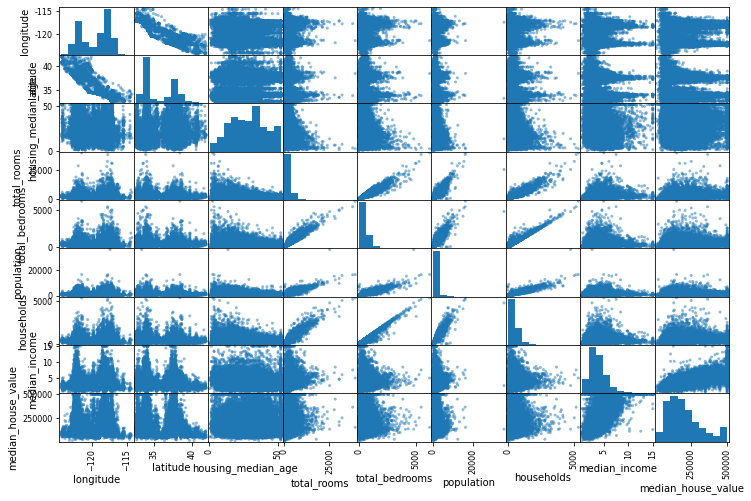

In [100]:
from pandas.plotting import scatter_matrix

scatter_matrix(housing, figsize=(12, 8))
plt.show()

Đối với những biểu đồ mà trục tung và trục hoành đều là 1 thuộc tính. Thì dĩ nhiên, đồ thị của nó sẽ là đường chéo chính. Điều này không hữu ích cho lắm nên thay vào đó pandas vẽ biểu đồ tần số thay cho biểu đồ tương quan trong trường hợp này.

Quá nhiều biểu đồ nhiều khi gây rối cho chúng ta. Thường chỉ nên tập trung vào 1 vài thuộc tính hứa hẹn sẽ tương quan cao với giá nhà trung vị.

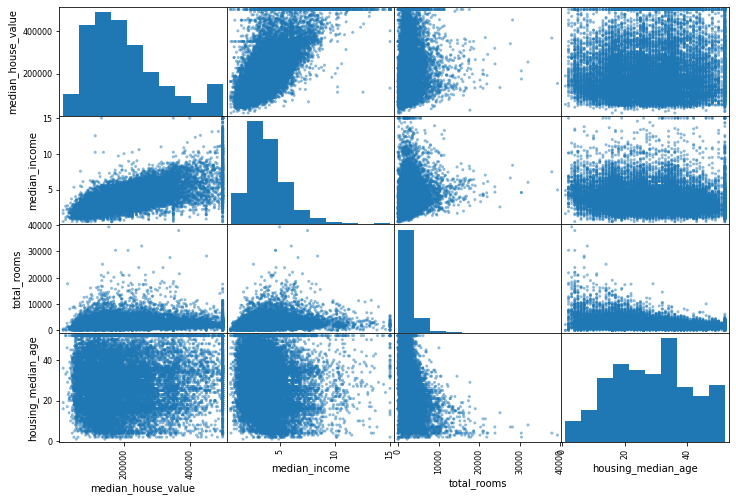

In [101]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

Tập trung vào 1 số biểu đồ khả nghi để phân tích. Như biểu đồ tương quan giữa giá nhà trung vị và thu nhập trung vị.

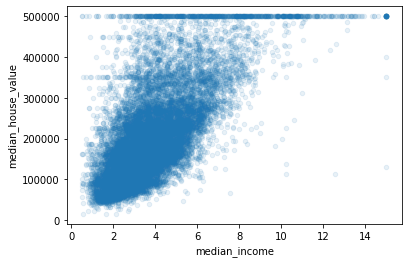

In [102]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

Nhận xét:

Nhìn vào biểu đồ, thì thấy giá nhà trung vị và thu nhập trung vị có sự tương quan dương khá lớn. 

Ta cũng thấy 1 đường ngang ở mức 500.000\$ đó chính là mức giá trần mà chúng ta đã biết. Tuy nhiên, biểu đồ cũng tiết lộ 1 số đường ngang khó nhận thấy ngay: 1 đường ở mức 450.000\$, 1 đường ở mức 350.000\$, 1 đường khác ở mức 280.000\$ và 1 vài đường ở dưới nữa. *Bạn có thể thử loại bỏ các quận tương ứng để ngăn thuật toán tái tạo lại những khuôn mẫu kỳ lạ này trong quá trình học (???)*.

## Thí nghiệm Kết hợp các Thuộc tính


Một điều thú vị nên làm trước khi đến khâu chuẩn bị dữ liệu để train mô hình là thử nghiệm kết hợp các thuộc tính. Ví dụ, ta thấy thông tin tổng số phòng trong 1 quận sẽ không mấy có ích. Nên ta kết hợp thuộc tính tổng số phòng với số hộ gia đình để tạo ra 1 thuộc tính mới: số phòng của mỗi hộ gia đình. Tương tự, ta cũng tạo thêm các thuộc tính như: Số phòng ngủ trên tổng số phòng, số người trong mỗi gia đình.


In [103]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]


Sau khi có thuộc tính mới, ta xem sự tương quan của nó với giá nhà trung vị.

In [104]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Kết quả không tệ! Thuộc tính bedrooms_per_room có độ tương quan lớn hơn hẳn 2 thuộc tính tạo ra nó là: total_rooms và total_bedrooms. Thuộc tính rooms_per_household cũng tốt hơn 2 thuộc tính tạo ra nó là: total_rooms và households.

Việc kết hợp thuộc tính không cần quá tỉ mỉ. Ta chỉ cần có 1 khởi đầu tốt và nhanh chóng để hiểu dữ liệu, từ đó tạo ra các nguyên mẫu đầu tiên tương đối tốt. Nhưng đây là quá trình lặp lại: khi đã có nguyên mẫu, ta phân tích đầu ra của nó để có nhiều thông tin hơn và quay lại bước khám phá này.

In [105]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847


# Chuẩn bị Dữ liệu cho các Thuật toán Học máy

Giờ là lúc ta cần chuẩn bị dữ liệu cho các thuật toán Học máy. Đương nhiên, ta không nên làm thủ công mà nên viết các hàm để xử lý việc này vì:
  + Việc này cho phép ta áp dụng các phép biến đổi trên bất cứ tập dữ liệu nào (ví dụ khi ta có dữ liệu mới).
  + Ta dần có thể xây dựng 1 thư viện các hàm biến đổi để có thể tái sử dụng trong tương lai.
  + Ta có thể dùng các hàm này trong hệ thống thực để biến đổi dữ liệu mới trước khi đưa vào thuật toán.
  + Ta có thể dễ dàng thử nhiều cách biến đổi và xem tổ hợp nào hoạt động tốt nhất.

Nhưng trước hết, hãy quay lại với tập huấn luyện ban đầu (bằng cách copy strat_train_set một lần nữa). Cùng với đó, hãy tách các thuộc tính và nhãn, vì ta không nhất thiết muốn áp dụng phép biến đổi trên cả hai (chú ý rằng phương thức drop() tạo 1 bản sao của dữ liệu và không làm ảnh hưởng tới strat_train_set): 

In [106]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Làm sạch Dữ liệu

Đa phần các thuật toán học máy không làm việc được với đặc trưng bị thiếu nên ta cần viết hàm để xử lý điều này. Trước đó, thuộc tính total_bedrooms có một vào giá trị bị thiếu, nên ta hãy xử lý nó. Ta có 3 lựa chọn:
  + Loại bỏ các quận bị thiếu.
  + Loại bỏ toàn bộ thuộc tính.
  + Gán 1 giá trị nào đó (0, Trung bình, Trung vị, v.v).

Ta có thể thực hiện những việc này dễ dàng bằng các phương thức dropna(), drop(), fillna() của DataFrame:
```housing.dropna(subset=["total_bedrooms"])
housing.drop("total_bedrooms", axis=1)
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)
```




Xem những quận bị thiếu dữ liệu.

In [107]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


Nếu chọn cách thứ 3, ta nên tính giá trị trung vị và gán nó cho các giá trị bị thiếu. Và đừng quên lưu lại giá trị này vì ta còn cần nó để fillna cho các mẫu bị thiếu giá trị trong tập kiểm tra và trong dữ liệu mới.

Trong thực tế, mọi thuộc tính đều có thể bị thiếu giá trị. Do đó, ta nên tính trung vị của tất cả các thuộc tính một lượt để khi bất cứ thuộc tính nào bị thiếu thì ta có sẵn giá trị trung vị để thay.

Scikit-Learn cung cấp 1 lớp hữu ích để xử lý giá trị bị thiếu: SimpleImputer. Để sử dụng nó, đầu tiên ta cần tạo một thực thể của lớp SimpleImputer và chỉ định rằng ta muốn thay thế những giá trị bị thiếu bằng giá trị trung vị của thuộc tính.

In [108]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy="median")

Vì trung vị chỉ có thể được tính với các thuộc tính số, do đó ta cần tạo bản sao của dữ liệu không chứa thuộc tính văn bản ocean_proximity.

In [109]:
housing_num = housing.drop("ocean_proximity", axis=1)

Giờ ta có thể khớp thực thế imputer với dữ liệu bằng phương thức fit().

In [110]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

Thực thể imputer đơn thuần chỉ tính trung vị của tất cả các thuộc tính số và lưu các giá trị đó vào biến **statistic_** của nó.

In [111]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Kiểm tra để đảm bảo rằng điều này giống như tính toán thủ công giá trị trung bình của từng thuộc tính.

In [112]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Giờ ta có thể dùng imputer "đã được huấn luyện" để biến đổi tập huấn luyện bằng cách thay thế dữ liệu thiếu bằng giá trị trung vị đã tính được:

In [113]:
X = imputer.transform(housing_num)

Kết quả là một mảng Numpy thuần chứa những đặc trưng đã bị biến đổi. Nếu muốn chuyển nó về dạng DataFrame của pandas chỉ cần:

In [114]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                           index=housing_num.index)

In [115]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


## Xử lý các Thuộc tính Văn bản và Hạng mục.

Trong bài toán này, thì có thuộc tính ocean_proximity là thuộc tính hạng mục. Hầu hết các thuật toán Học máy thích làm việc với số hơn. Do đó, ta nên chuyển đổi các hạng mục này từ dạng văn bản sang dạng số. Để làm điều này ta có thể sử dụng lớp OrdinalEncoder của Scikit-Learn:

In [116]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [117]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [118]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Tuy nhiên, với cách biểu diễn này thì các thuật toán Học máy sẽ giả định rằng 2 giá trị gần nhau sẽ giống nhau hơn 2 giá trị cách xa nhau. Cụ thể điều này sẽ không thành vấn đề trong 1 số trường hợp (ví dụ: các hạng mục có thứ tự: "Kém", "Trung bình", "Tốt" và "Xuất Sắc"), nhưng rõ ràng điều này không đúng với thuộc tính ocean_proximity (ví dụ: hạng mục 0 và 4 rõ ràng gần hơn hạng mục 0 và 1).

Để khắc phục vấn đề này, có 1 giải pháp phổ biến là sử dụng thuộc tính dạng nhị phân cho mỗi hạng mục. Phương pháp này gọi là one-hot encoding. Scikit-Learn cung cấp lớp OneHotEncoder giúp biến đổi các giá trị hạng mục thành các vector one-hot:

In [119]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Mặc định, lớp `OneHotEncoder` trả về một mảng thưa, nhưng ta có thể chuyển đổi nó thành một mảng dày đặc nếu cần bằng cách gọi phương thức `toarray()`:

In [120]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Một cách khác, bạn có thể đặt `sparse=False` khi tạo lớp `OneHotEncoder`:

In [121]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [122]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Bộ biến đổi tùy chỉnh

Quan trọng: đọc trong sách (Trang 60).

Hãy tạo một chuyển đổi tùy chỉnh để thêm các thuộc tính bổ sung:

In [123]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Lưu ý rằng rôi đã cố gắng mã hóa các chỉ số (3, 4, 5, 6) để có sự ngắn gọn và rõ ràng trong cuốn sách, nhưng sẽ gọn gàng hơn nhiều nếu bạn lấy chỉ số một cách linh động, như thế này:

In [124]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

Ngoài ra, `housing_extra_attribs` là một mảng NumPy, chúng ta đã mất tên cột (thật không may, đó là vấn đề với Scikit-Learn). Để khôi phục `DataFrame`, bạn có thể chạy như sau:

In [125]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


## Co dãn đặc trưng

Một trong những biến đổi quan trọng nhất đối với dữ liệu là *co dãn đặc trưng (feature scaling)*. 

Trừ một số thuật toán đặc biệt, các thuật toán Học máy thường không hoạt động tốt khi các đặc trưng có khoảng giá trị khác nhau. Ví dụ: Trong tập dữ liệu nhà ở, giá trị total_rooms nằm trong khoảng từ 6 - 39.320. Trong khi thu nhập trung vị chỉ nằm trong khoảng từ 0 - 15.

Hai cách phổ biến nhất để đưa các đặc trưng về cùng 1 khoảng giá trị là: *Chuẩn hóa (Normalization)* và *Chuẩn tắc hóa (Standardization)*.


Chuẩn hóa (Normalization): hay còn gọi là co dãn min-max. Phương pháp này hướng tới việc khiến cho giá trị của đặc trưng co dãn sao cho chúng nằm trong khoảng từ 0 - 1. Chúng ta thực hiện điều này bằng cách trừ đi giá trị nhỏ nhất và chia so hiệu của giá trị lớn nhất và giá trị nhỏ nhất. Scikit-Learn cung cấp bộ biến đổi có tên là MinMaxScaler để thực hiện phép biến đổi này. Bộ biến đổi này chưa tham số **feature_range** cho phép thay đổi khoảng giới hạn trong trường hợp ta không muốn sử dụng khoảng [0, 1].

Chuẩn tắc hóa (Standardization): phương pháp này không ràng buộc giá trị trong khoảng cụ thể. Điều này tuy không phù hợp với 1 số thuật toán (Ví dụ như mạng nơ-ron thường yêu cầu đầu vào nằm trong khoảng [0, 1]). Tuy nhiên, chuẩn tắc hóa lại ít bị ảnh hưởng bởi các điểm ngoại lai. Nói chung, là tùy trường hợp mà cân nhắc sử dụng cho phù hợp. Để thực hiện chuẩn tắc hóa, ta đầu tiên trừ giá trị trung bình, sau đó chia cho độ lệch chuẩn để phân phối thu được có phương sai đơn vị. Scikit-Learn cũng cung cấp một bộ biến đổi có tên StandardScaler để thực hiện phép biến đổi này.

## Pepline biến đổi

Pepline là 1 công cụ cực kỳ hữu dụng. Về cơ bản, **Pepline định nghĩa luồng hoạt động của dự án Học máy**. Do đó, nó khiến ta dễ dàng hình dung hơn về những gì dự án đang thực hiện. Ngoài ra, pepline còn cung cấp cho chúng ta sự linh hoạt đáng ngạc nhiên. Ta hoàn toàn có thể thay đổi các phương pháp xử lý dữ liệu hay các mô hình học máy bằng cách chỉ cần thay đổi vài dòng code. Việc có thể linh hoạt thay đổi khiến ta có thể thử nghiệm được nhiều phương pháp học máy hơn. Đơn giản, logic, tiết kiệm thời gian, dễ dàng để thử nghiệm, thuận tiện cho việc bảo trì, nâng cấp... những đặc điểm đó đều có mặt ở Pepline.

Bây giờ chúng ta hãy xây dựng một pipeline để tiền xử lý các thuộc tính số:

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [127]:
housing_num_tr


array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [128]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [129]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [130]:
housing_prepared.shape

(16512, 16)

Để tham khảo, đây là giải pháp cũ được dựa trên transformer `DataFrameSelector` (để chỉ chọn một tập con của các cột trong Pandas `DataFrame`), và `FeatureUnion`:

In [131]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Bây giờ, hãy kết hợp tất cả các thành phần này thành một pipeline lớn sẽ tiền xử lý cả số và phân loại đặc trưng:

In [132]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [133]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [134]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

Kết quả tương tự như `ColumnTransformer`:

In [135]:
np.allclose(housing_prepared, old_housing_prepared)

True

# Chọn và Huấn luyện Mô hình

Một dự án Học máy thường mất khoảng 80% thời gian để chuẩn bị dữ liệu. Ta đã làm xong giai đoạn đó, giờ đã tới lúc làm việc với các mô hình.

## Huấn luyện và Đánh giá trên tập Huấn luyện

Nhờ sự hỗ trợ của các thư viện Học máy mà việc lựa chọn mô hình trở nên khá đơn giản. Việc của bạn chỉ là suy nghĩ xem nên chọn mô hình nào trong số chúng để đạt hiệu suất tốt nhất.

Đầu tiên, hãy thử huấn luyện một mô hình Linear Regression:

In [136]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Giờ ta thử nó với 1 vài mẫu dữ liệu của tập huấn luyện:

In [137]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Đây là các labels mà mô hình dự đoán. Ta so sánh chúng với giá trị thực tế:

In [138]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Ta có thể thấy các dự đoán vẫn chưa đạt được độ chính xác mà ta mong muốn.
Ta đo RMSE của mô hình trên toàn bộ tập huấn luyện bằng phương thức mean_squared_error():

In [141]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_predictions, housing_labels)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Giá nhà trung bình nằm trong khoảng 120.000\$ - 265.000\$. Nên sai lệch trung bình khoảng 68.628\$ là quá lớn. Chắc chắn ta đã bị Underfitting. Có vài cách để khắc phục tình trạng Underfitting: Giảm ràng buộc mô hình, cung cấp thêm các đặc trưng hữu ích, sử dụng một mô hình mạnh hơn (phức tạp hơn). Trong trường hợp này, ta thử sử dụng 1 mô hình mạnh hơn để xem có hiệu quả hay không.

Một mô hình mạnh mẽ có khả năng tìm ra cả những quan hệ phi tuyến trong dữ liệu: DecisionTreeRegressor có thể sẽ hữu ích.

In [140]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Ta cũng dùng chuẩn RMSE để đo chất lượng mô hình:

In [142]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_predictions, housing_labels)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Không có sai lệch. Đây không phải là một tín hiệu tốt. Rất có khả năng chúng ta đã bị Overfitting (Quá khớp). Vì vậy, ta luôn phải dành riêng một phần của tập huấn luyện cho kiểm định và phần còn lại dùng để huấn luyện mô hình. Tập kiểm định có thể giúp ta xác định được siêu tham số điều chuẩn phù hợp, nhờ đó mà ta có thể tránh được hiện tượng Overfitting.

## Kiểm định chéo: Phương pháp đánh giá tốt hơn

Ta hoàn toàn có thể sử dụng lại hàm train_test_split() để chia tập train_set thành 2 phần: 1 phần dùng để huấn luyện (train_set) và 1 phần làm tập kiểm định (validation_set). Phương pháp này hoạt động tốt.

Tuy nhiên, ta sẽ thử 1 phương pháp kiểm định tuyệt vời khác: K-fold cross-validation. Phương pháp này rất đơn giản: Chia tập huấn luyện thành K tập -> Chọn lần lượt 1 tập trong số K tập này làm tập kiểm định, K-1 tập còn lại dùng để huấn luyện mô hình -> Như vậy, ta huấn luyện và kiểm định mô hình K lần, sau đó chia trung bình scores của K lần này thì ta sẽ được kết quả tương đối tốt.

Đoạn code dưới đây ta chọn K = 10 (tức là chia tập huấn luyện thành 10 tập con). Mô hình sẽ được huấn luyện 10 lần. Và kết quả trả về sẽ là 1 mảng chứa điểm số đánh giá của 10 lần đó.

In [145]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_score = np.sqrt(-scores)

Lưu ý:
  + cross_val_score() làm việc với hàm lợi ích (càng cao càng tốt) thay vì một hàm chi phí (càng thấp càng tốt), nên hàm là hàm đối của MSE (tức có giá trị âm). Do đó, ta phải tính **-score** trước khi lấy căn bậc 2.

In [147]:
# Hàm show điểm: Điểm RMSE tương ứng với 10 lần train, Điểm RMSE trung bình và cả độ lệch chuẩn.
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

Điểm khi áp dụng K-fold cross-validation với mô hình DecisionTreeRegressor

In [148]:
display_scores(tree_rmse_score)

Scores: [70727.05443015 67091.15828678 69461.78459057 69797.5158603
 70957.61371465 76509.01250647 71404.48450332 70734.41469391
 76624.10524018 68933.0299553 ]
Mean: 71224.01737816345
Standard deviation: 2918.0792192487206


Giờ thì DecisionTreeRegressor không hoạt động tốt như trước nữa, thậm chí còn tệ hơn cả LinearRegression. Tuy nhiên, phương pháp K-fold cross-validation không chỉ giúp ta ước tính chất lượng mô hình, mà nó còn đánh giá độ chính xác của ước tính này (tức độ lệch chuẩn). Ta không có được thông tin này nếu chỉ dùng 1 tập kiểm định. Tuy nhiên, áp dụng K-fold cross-validation sẽ tốn nhiều chi phí huấn luyện hơn vì nó phải huấn luyện tới K lần.

Ta cũng áp dụng K-fold trên LinearRegression để so sánh:

In [152]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [153]:
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


Ta thấy rằng, DecisionTreeRegresor quá khớp nặng tới mức khiến nó hoạt động tệ hơn cả LinearRegression.

Ta sẽ thử với 1 mô hình nữa: RandomForestRegressor.

In [154]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [155]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

Áp dụng K-fold với RandomForestRegressor.

In [156]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


Kết quả này quả thực tốt hơn khá nhiều. Tuy nhiên, lưu ý rằng điểm số trên tập huấn luyện thấp hơn nhiều so với trên tập kiểm định. Điều này có nghĩa là mô hình vẫn hơi bị quá khớp trên tập huấn luyện. Một vài phương án cho điều trị "quá khớp": Thu thập thêm nhiều dữ liệu, đơn giản hóa mô hình, ràng buộc mô hình... Tuy nhiên, ta nên thử nhiều loại mô hình khác nhau như: SVM, Neuro-Network...  để xem mô hình nào khả thi nhất trước khi tập trung vào việc tinh chỉnh mô hình.